In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

#make plots inline using jupyter magic
%matplotlib inline

import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import datasets, linear_model, metrics


import matplotlib as mpl
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
#Balanced RF Classifier
from imblearn.ensemble import BalancedRandomForestClassifier as BRF

from IPython.display import Markdown as md  #enable markdown within code cell
from IPython.display import display, Math, Latex

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix
import time
import random
import scipy

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, precision_recall_curve, make_scorer,f1_score
from sklearn.metrics import precision_recall_curve as PRC
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from numpy.fft import fftn

## Homemade code imports
import metrics

data_dir = '/run/media/mnewlin/_userdata/uhnds/'
original_netflow_data_dir = data_dir + 'network/extracted/'
original_netflow_file = 'netflow_day-02'
fake_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/fake/'
real_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/real/'
real_file = 'netflow_day-02'
# Dataset dependent number of cols
N_COLS = 20
np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [7]:
"""
    Function to read in a single real sample from a given directory based
    on the desired length of the sample.
"""
def load_real_sample(sample_num, sample_length=100):

    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1
        
    load_file = real_file + '_sample_{}.txt'.format(sample_num)
    filename = real_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.float64)
    data = np.array(df)
    return data

"""
    Function to read in a single fake sample from a given directory based
    on the desired length of the sample.
"""
def load_fake_sample(sample_num, sample_length=100):
    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1

    load_file = real_file + '_random_sample_{}.txt'.format(sample_num)
    filename = fake_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.float64)
    data = np.array(df)
    return data

def load_n_samples(real=True, sample_length=100, num_samples=100, random_state=69):
    sample_set = np.array([])
    sample_range = 0
    if sample_length <= 1000:
        sample_range = 10000
    elif sample_length <= 10000:
        sample_range = 2000
    elif sample_length <= 100000:
        sample_range = 1160
    # Seed random samples for repeatability    
    random.seed(a=random_state)
    sample_list = random.sample(range(sample_range), num_samples)
    if real:
        for num in sample_list:
            data = load_real_sample(sample_length=sample_length, sample_num=num)
            sample_set = np.append(sample_set, data)
    else:
        for num in sample_list:
            data = load_fake_sample(sample_length=sample_length, sample_num=num)
            sample_set = np.append(sample_set, data)
    sample_set = np.reshape(sample_set, newshape=(num_samples, sample_length, N_COLS))
    return sample_set

def create_sample_mix(ratio, sample_length=100, num_samples=100, random_state=69):
    sample_range = 0
    if sample_length <= 1000:
        sample_range = 10000
    elif sample_length <= 10000:
        sample_range = 2000
    elif sample_length <= 100000:
        sample_range = 1160
    
    #mix_set = np.zeros((num_samples, sample_length, N_COLS))
    bound_val_real = np.around(((1-ratio)*num_samples), decimals=2)
    bound_val_fake = np.around((ratio)*num_samples, decimals=2)
    bound_val_real = int(bound_val_real) # How many real samples there should be
    bound_val_fake = int(bound_val_fake) # How many fake samples there should be
    
    real_data = load_n_samples(real=True, num_samples=num_samples, sample_length=sample_length, random_state=random_state) 
    fake_data = load_n_samples(real=True, num_samples=num_samples, sample_length=sample_length, random_state=random_state)
    real_section = real_data[:bound_val_real]
    fake_section = fake_data[:bound_val_real]
    mix_set = np.append(real_section, fake_section)
    mix_set = np.reshape(mix_set, newshape=(num_samples, sample_length, N_COLS))
    return mix_set

"""
    Takes in a set S of shape (num_samples, sample_length, N_COLS)
    and returns the PCA transform of each sample of shape (num_samples, N_COLS, N_COLS)
"""
def pca_transform_set(S):
    pca = PCA()
    num_samples = S.shape[0]
    sample_length = S.shape[1]
    s_pca = np.zeros((num_samples, sample_length, N_COLS))
    for x in range(num_samples):
        pca.fit(S[x])
        s_pca[x] = pca.components_
    return s_pca
    

In [8]:
def load_real_host_sample(sample_num, sample_length=1000):
    directory = '/run/media/mnewlin/_userdata/uhnds/host/unconverted/real/tfidf/'
    real_host_data_dir = directory + 'samples_{}/'.format(sample_length)
        
    load_file = real_host_data_dir + 'tfidf_sample_{}.csv'.format(sample_num)
    df = pd.read_csv(load_file, dtype=np.float64)
    data = np.array(df)
    return data

def load_fake_host_sample(sample_num, sample_length=1000,dist='uniform'):
    directory = '/run/media/mnewlin/_userdata/uhnds/host/unconverted/fake/{}/'.format(dist)
    
    fake_host_data_dir = directory + 'samples_{}/'.format(sample_length)
        
    load_file = fake_host_data_dir + 'tfidf_sample_{}.csv'.format(sample_num)
    df = pd.read_csv(load_file, dtype=np.float64)
    data = np.array(df)
    return data

def load_n_host_samples(real=True, sample_length=100, num_samples=100, random_state=69, dist='uniform'):

    sample_set = np.array([])
    sample_range= 10000
    random.seed(a=random_state)
    sample_list = random.sample(range(sample_range), num_samples)
    if real:
        for num in sample_list:
            data = load_real_host_sample(sample_length=sample_length, sample_num=num)
            sample_set = np.append(sample_set, data)
    else:
        for num in sample_list:
            data = None
            if dist == 'uniform':
                data = load_fake_host_sample(sample_length=sample_length, sample_num=num, dist='uniform')
            else:
                data = load_fake_host_sample(sample_length=sample_length, sample_num=num, dist='normal')
            sample_set = np.append(sample_set, data)
    sample_set = np.reshape(sample_set, newshape=(num_samples, sample_length, N_COLS))
        
    return sample_set

## Time Efficiency

In [8]:
num_sample_list = [5*(n+1)*100 for n in range(20)]
num_sample_list.insert(0,100)
print(num_sample_list)
num_metrics = 11
num_sample_list = np.array(num_sample_list)
time_list = np.zeros((num_sample_list.size))
time_data_all = np.zeros((num_sample_list.size, num_metrics+1))
time_data_all[:,0] = num_sample_list
names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd', 'fid']
cols = ['Runtime: ' + x for x in names]
cols.insert(0,'Number of Samples')


sample_length = 1000

[100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]


In [9]:

for i in range(num_sample_list.size):
    sample_set_size = num_sample_list[i]
    S1 = load_n_host_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=69, dist='uniform')
    S2 = load_n_host_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=42, dist='uniform')
    G1 = load_n_host_samples(real=False, sample_length=sample_length, num_samples=sample_set_size, random_state=69, dist='uniform')
    G2 = load_n_host_samples(real=False, sample_length=sample_length, num_samples=sample_set_size, random_state=42, dist='uniform')
    
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='lp', p=2, r=2)
    time_data_all[i,1] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='lp', p=1, r=1)
    time_data_all[i,2] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='lp', p=0.5, r=0.5)
    time_data_all[i,3] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='lp', p=0.75, r=0.75)
    time_data_all[i,4] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='cosine')
    time_data_all[i,5] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='mahalanobis')
    time_data_all[i,6] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='wasserstein')
    time_data_all[i,7] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='entropy', standardized=False)
    time_data_all[i,8] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='perplexity', standardized=False)
    time_data_all[i,9] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='mmd', G1=G1, G2=G2)
    time_data_all[i,10] = t_diff
    
    pca = PCA()
    real_set_1 = np.zeros((sample_set_size, N_COLS, N_COLS))
    real_set_2 = np.zeros((sample_set_size, N_COLS, N_COLS))
    for x in range(sample_set_size):
        pca.fit(S1[x])
        real_set_1[x] = pca.components_
        
        pca.fit(S2[x])
        real_set_2[x] = pca.components_
    _,t_diff = metrics.time_score_set(S1=real_set_1, S2=real_set_2, sample_length=N_COLS, num_samples=sample_set_size, metric='fid')
    time_data_all[i,11] = t_diff
    print(sample_set_size)
time_eff_df = pd.DataFrame(data=time_data_all, columns=cols)
print("Finished")
display(time_eff_df.head())


100
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
Finished


,Number of Samples,Runtime: Euclidean,Runtime: Manhattan,Runtime: lp: p=r=0.5,Runtime: lp: p=r=0.75,Runtime: cosine,Runtime: mahalanobis,Runtime: wasserstein,Runtime: entropy,Runtime: perplexity,Runtime: mmd,Runtime: fid
0,100.0,0.097201,0.108575,0.233952,0.213666,0.244991,21.678632,0.565443,1.624450,1.323655,5.477052,0.763395
1,500.0,0.518569,0.552779,1.201922,1.125354,0.911012,107.212674,3.082426,7.408498,10.494967,39.505104,3.610181
2,1000.0,1.136816,1.061966,2.253606,2.229029,1.859999,214.363126,4.527078,17.863301,15.307363,68.691054,6.944791
3,1500.0,1.523893,1.406959,3.526288,3.152235,3.176596,316.188397,7.871027,22.966104,24.232187,81.560157,12.572431
4,2000.0,2.325309,1.685861,4.577591,3.533738,3.461321,425.166521,10.061076,29.834790,31.819123,106.645622,14.048424


In [15]:
#outfile='/home/mnewlin/git/AFIT/Thesis/code/results/time_efficiency_results.csv'
#time_eff_df.to_csv(outfile)
"""
wass_diffs = np.zeros((num_sample_list.size,))
for i in range(num_sample_list.size):
    sample_set_size = num_sample_list[i]
    S1 = load_n_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=69)
    S2 = load_n_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=42)
    _, wass_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='wasserstein')
    wass_diffs[i] = wass_diff
    print(sample_set_size, wass_diff)
print("Finished")
"""

100 0.3096740245819092
500 1.2164556980133057
1000 2.453577995300293
1500 3.6714236736297607
2000 4.872739553451538
2500 6.1920082569122314
3000 7.315247297286987
3500 8.446828842163086
4000 9.519686937332153
4500 10.84392261505127
5000 11.98257565498352
5500 13.231746912002563
6000 14.595314979553223
6500 15.757635354995728
7000 17.01756000518799
7500 18.00524592399597
8000 19.447341918945312
8500 20.329765558242798
9000 22.04736089706421
9500 22.900646209716797
10000 24.028891563415527
Finished


'\nsample_set_size = 1000\nS1 = load_n_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=69)\nS2 = load_n_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=42)\nts = time.time()\nfor i in range(sample_set_size):\n    metrics.wasserstein_dist(S1[i], S2[i])\nte = time.time()\nt_diff = te-ts\nprint(t_diff)\n'

In [17]:
#time_eff_df.at[:,'Runtime: wasserstein'] = wass_diffs
#display(time_eff_df.head())

,Number of Samples,Runtime: Euclidean,Runtime: Manhattan,Runtime: lp: p=r=0.5,Runtime: lp: p=r=0.75,Runtime: cosine,Runtime: mahalanobis,Runtime: wasserstein,Runtime: entropy,Runtime: perplexity,Runtime: mmd,Runtime: fid
0,100.0,0.042104,0.041378,0.093954,0.091635,0.089536,6.483543,0.309674,0.643925,0.635140,8.592701,0.366710
1,500.0,0.211824,0.191801,0.412017,0.441723,0.429452,37.315845,1.216456,3.171206,3.298879,46.080745,1.620127
2,1000.0,0.417698,0.414131,0.853007,0.876126,0.882164,71.234659,2.453578,6.327049,6.315486,88.930807,3.303151
3,1500.0,0.592239,0.572699,1.272341,1.282392,1.258052,106.159819,3.671424,9.341181,9.416537,133.281123,4.913507
4,2000.0,0.863315,0.772867,1.686367,1.722260,1.702844,140.371236,4.872740,12.451819,12.395903,178.559145,6.679852


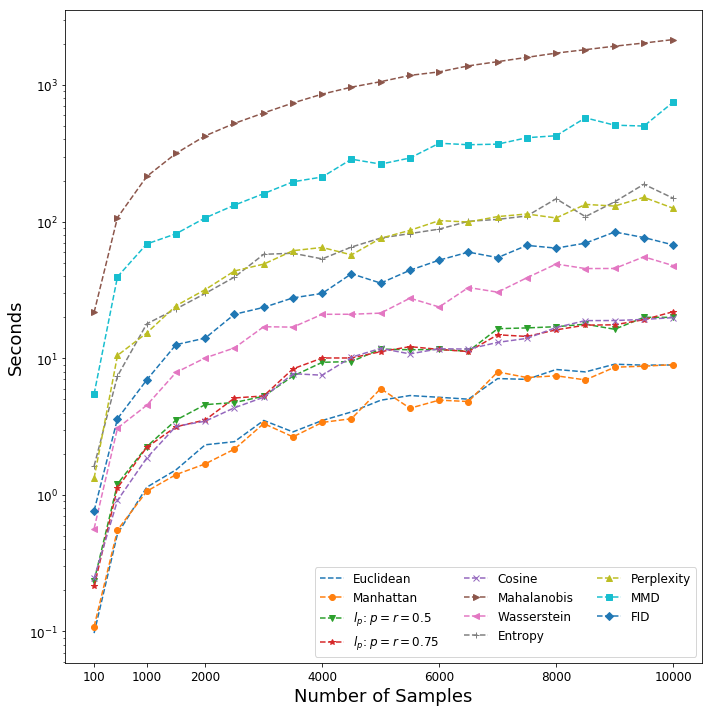

In [10]:
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
num_metrics = len(names)
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    plt.semilogy(time_eff_df.loc[:,'Number of Samples'], time_eff_df.iloc[:,i+1], markers[i], label=names[i])
plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("Seconds", fontsize=18)
plt.xticks([100, 1000, 2000, 4000, 6000, 8000, 10000], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, ncol=3)
plt.tight_layout()
plt.savefig('figures/efficiency/eps/host/time_efficiency_host.eps')
plt.savefig('figures/efficiency/png/host/time_efficiency_host.png')
plt.show()
    
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/time_efficiency_host_results.csv'
time_eff_df.to_csv(outfile)

## Sample Efficiency

### Untransformed Data

In [4]:
num_metrics = 10
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
sample_efficiency_results_jsd = np.zeros((2, num_metrics, len(num_sample_list)))
counter = 0
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/run/media/mnewlin/_userdata/results_data/results/untrans/'
    real_data_untrans = pd.read_csv(indir+'real_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(real_data_untrans.head())
    fake_data_untrans = pd.read_csv(indir+'fake_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_untrans
    fake_data = fake_data_untrans
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 5
        grid_y = 2
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd 
        plt.close()
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5
    #KLD_data_all = np.zeros((num_metrics, n_repeats))
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)
    """
    Add Jensen Shannon Attempt
    
    """
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    """
    """
    kld_data = np.array([euc_KLD, man_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    jsd_data = np.array([euc_JSD, man_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD])
    sample_efficiency_results[0,:,counter] = kld_data
    sample_efficiency_results_jsd[0,:,counter] = jsd_data
    #sample_efficiency_results[1,:,counter] = KLD_data_untrans.loc[:,'Std. Dev.']
    counter += 1    
    #KLD_data_all[:,i] = kld_data.T
    

In [5]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)
#sample_eff_res_std_df = pd.DataFrame(data=sample_efficiency_results[1], index=names, columns=num_sample_list)
#display(sample_eff_res_std_df)
jsd_df = pd.DataFrame(data=sample_efficiency_results_jsd[0], index=names, columns=num_sample_list)
display(jsd_df)

,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,1.028608,1.858121,1.903830,1.361445,1.443913,1.601041,1.542161,1.781100,1.662989,1.763350,2.058552
Manhattan,0.281119,0.302565,0.227552,0.158969,0.146232,0.185034,0.192233,0.192628,0.207448,0.221786,0.226754
lp: p=r=0.5,3.262993,7.160395,7.337312,5.376670,6.018569,5.950881,6.137729,6.453533,6.505108,6.554041,7.448333
lp: p=r=0.75,1.876092,4.161512,4.332673,3.150628,3.116033,3.172940,3.148753,3.384921,3.405356,3.583583,4.311180
cosine,6.343285,3.605490,2.747027,2.817403,2.637750,2.667019,2.826259,2.601064,2.957623,2.844301,3.101281
mahalanobis,7.326701,5.737633,5.091530,5.320477,5.404024,4.672071,3.994273,4.075488,3.588145,3.410801,2.986658
wasserstein,8.765616,8.866530,8.911139,8.905870,8.912438,8.918579,8.940733,8.942380,8.947463,8.945541,8.963983
entropy,3.094676,3.467485,3.562170,3.194702,3.238249,3.210822,3.140931,3.159152,3.148540,3.268730,3.267573
perplexity,4.846237,4.695175,4.519391,4.511347,4.354355,4.228685,4.190444,4.041028,3.922029,4.300913,4.171530
mmd,0.081689,0.030026,0.021203,0.011604,0.008661,0.006272,0.006901,0.004972,0.004379,0.004657,0.004299


,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,0.399265,0.514341,0.523166,0.454565,0.464188,0.475633,0.481293,0.508169,0.493613,0.509228,0.537748
Manhattan,0.243089,0.244060,0.231184,0.187104,0.192338,0.210231,0.214553,0.217112,0.222611,0.226211,0.233759
lp: p=r=0.5,0.671567,0.894036,0.911245,0.800298,0.837882,0.830007,0.833757,0.856530,0.846397,0.851406,0.905857
lp: p=r=0.75,0.508087,0.709954,0.721186,0.630513,0.633299,0.634789,0.645049,0.675485,0.669309,0.680872,0.728195
cosine,0.950514,0.834015,0.777927,0.808172,0.799589,0.776951,0.761556,0.736949,0.753458,0.741202,0.754801
mahalanobis,0.999097,0.887759,0.857213,0.840636,0.839565,0.793345,0.759054,0.762019,0.750485,0.724209,0.712370
wasserstein,1.000000,0.999610,0.999768,0.999870,0.999906,0.999895,0.999913,0.999921,0.999932,0.999939,0.999940
entropy,0.589535,0.651810,0.679444,0.608000,0.626671,0.623211,0.588904,0.594273,0.596124,0.613290,0.611340
perplexity,0.767953,0.753247,0.737909,0.733984,0.731486,0.722208,0.716641,0.706101,0.700530,0.728084,0.725859
mmd,0.163617,0.101479,0.085531,0.060542,0.053718,0.046557,0.047565,0.042048,0.039588,0.040294,0.039141


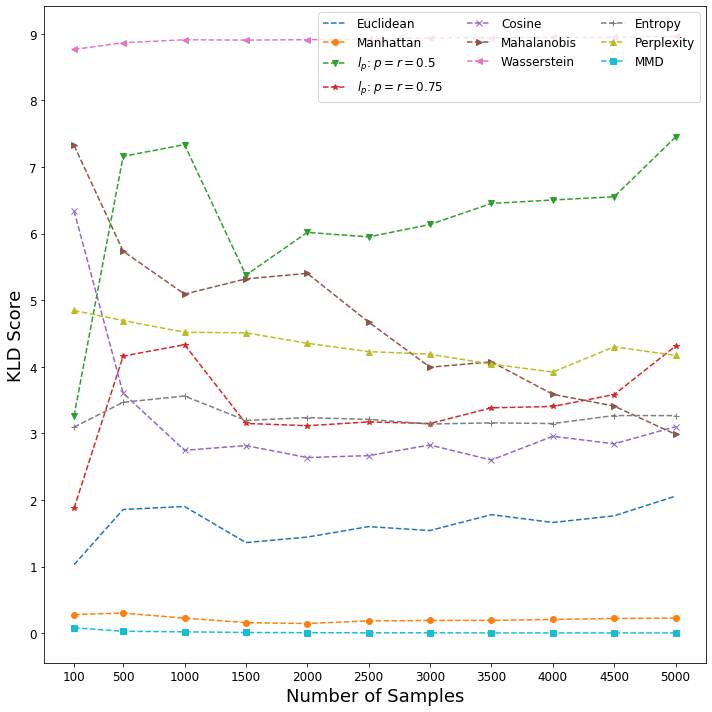

In [6]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))

fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(num_sample_list,fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(fontsize=12, ncol=3)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_untrans.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_untrans.png')
plt.show()

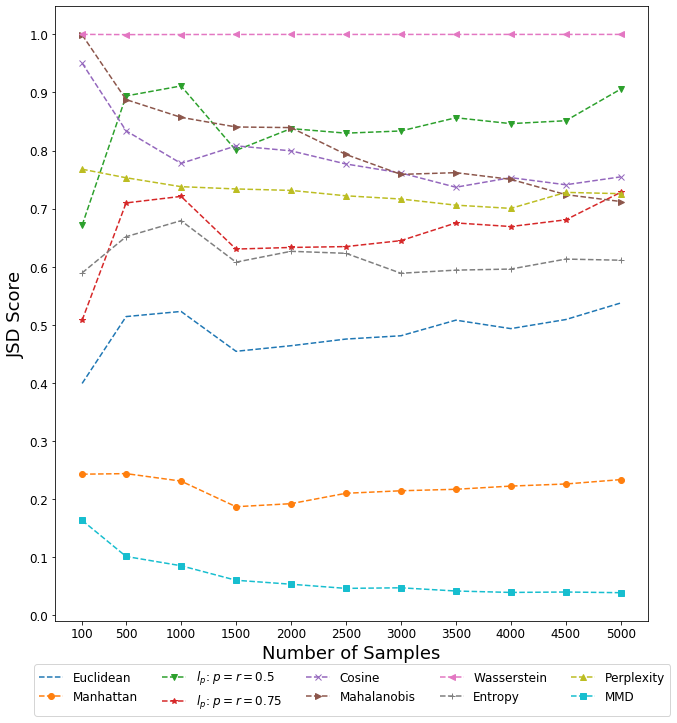

In [17]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(jsd_df.max().max()))
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = jsd_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("JSD Score", fontsize=18)
plt.xticks(num_sample_list,fontsize=12)
plt.yticks(np.arange(0,1.01,0.1), fontsize=12)
plt.legend(loc=(-0.035,-.155), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_untrans_jsd.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_untrans_jsd.png')
plt.show()

## Square Root

In [18]:
num_metrics = 10
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
sample_efficiency_results_jsd = np.zeros((2, num_metrics, len(num_sample_list)))
counter = 0
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/run/media/mnewlin/_userdata/results_data/results/sqrt/'
    real_data_sqrt = pd.read_csv(indir+'real_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(real_data_untrans.head())
    fake_data_sqrt = pd.read_csv(indir+'fake_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_sqrt
    fake_data = fake_data_sqrt
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 5
        grid_y = 2
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd 
        plt.close()
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)

    """
    Add Jensen Shannon Attempt
    
    """
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    """
    """
    kld_data = np.array([euc_KLD, man_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    jsd_data = np.array([euc_JSD, man_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD])
    sample_efficiency_results[0,:,counter] = kld_data
    sample_efficiency_results_jsd[0,:,counter] = jsd_data
    counter += 1    
    

In [19]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)
jsd_df = pd.DataFrame(data=sample_efficiency_results_jsd[0], index=names, columns=num_sample_list)
display(jsd_df)

,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,2.586051,3.775919,3.667488,2.954011,3.555982,3.508118,3.583950,3.444363,3.619526,3.590725,4.116898
Manhattan,1.610483,1.519595,1.624580,1.480909,1.534661,1.652480,1.530755,1.565944,1.447473,1.438141,1.624141
lp: p=r=0.5,4.138551,7.530077,7.652527,6.050572,6.329364,6.545431,6.411707,6.391871,6.501691,6.694645,7.774542
lp: p=r=0.75,3.182864,5.497566,5.531551,3.955134,4.787589,4.972466,4.951483,4.863459,4.964488,5.098543,5.948881
cosine,5.325244,2.479370,2.413245,2.308356,2.343024,2.180107,2.267244,2.439841,2.584976,2.618465,2.806652
mahalanobis,7.331707,5.741422,5.143463,5.398148,5.464629,4.742698,4.076562,4.146388,3.648510,3.475567,3.041433
wasserstein,8.527651,8.631868,8.688271,8.693248,8.698584,8.715363,8.741930,8.741114,8.738796,8.743297,8.762847
entropy,2.022561,2.289435,2.155850,2.034041,2.021996,1.997771,2.025464,1.960083,1.906804,2.030539,1.980342
perplexity,2.607807,2.551660,2.335075,2.419729,2.335249,2.210524,2.189174,2.095235,1.996961,2.114406,1.978463
mmd,0.134721,0.042231,0.021493,0.013878,0.013104,0.011348,0.010026,0.008865,0.008585,0.008793,0.008073


,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,0.534108,0.655274,0.679739,0.614755,0.651139,0.662667,0.667644,0.666818,0.678196,0.678025,0.730154
Manhattan,0.427378,0.474441,0.479059,0.455542,0.470259,0.490887,0.489739,0.494049,0.490632,0.489490,0.520170
lp: p=r=0.5,0.713817,0.915025,0.925478,0.812615,0.834358,0.842819,0.839450,0.844000,0.850490,0.850222,0.926523
lp: p=r=0.75,0.605732,0.777341,0.801707,0.699702,0.742544,0.761904,0.756739,0.754553,0.763981,0.762938,0.821349
cosine,0.901297,0.790050,0.748072,0.785041,0.788354,0.745376,0.720513,0.735847,0.716048,0.730290,0.737522
mahalanobis,0.999311,0.886284,0.864674,0.847344,0.845620,0.801316,0.768253,0.773123,0.761394,0.734396,0.720772
wasserstein,1.000000,0.999575,0.999757,0.999875,0.999906,0.999912,0.999919,0.999926,0.999937,0.999935,0.999940
entropy,0.458998,0.531972,0.516623,0.494940,0.498662,0.504700,0.505778,0.491258,0.480847,0.504561,0.504387
perplexity,0.539867,0.533962,0.524991,0.529050,0.528152,0.516120,0.513703,0.502234,0.494766,0.503794,0.502546
mmd,0.212550,0.116343,0.084655,0.068781,0.067083,0.062493,0.059509,0.056024,0.055412,0.055290,0.053611


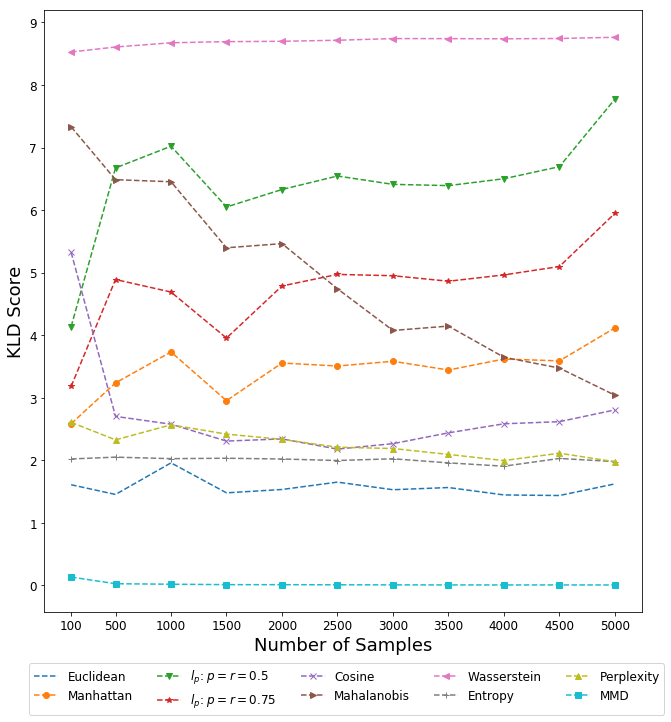

In [11]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(num_sample_list, fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(loc=(-0.025,-.17), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_sqrt.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_sqrt.png')
plt.show()

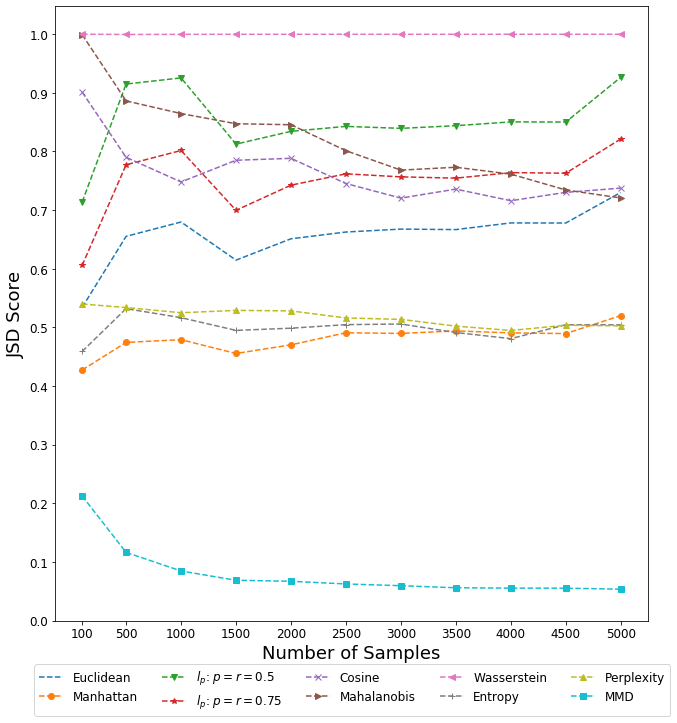

In [20]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(jsd_df.max().max()))
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = jsd_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("JSD Score", fontsize=18)
plt.xticks(num_sample_list,fontsize=12)
plt.yticks(np.arange(0,1.01,0.1), fontsize=12)
plt.legend(loc=(-0.035,-.155), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_sqrt_jsd.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_sqrt_jsd.png')
plt.show()

## Log

In [21]:
num_metrics = 10
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
sample_efficiency_results_jsd = np.zeros((2, num_metrics, len(num_sample_list)))
counter = 0
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/run/media/mnewlin/_userdata/results_data/results/log/'
    real_data_log = pd.read_csv(indir+'real_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(real_data_untrans.head())
    fake_data_log = pd.read_csv(indir+'fake_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_log
    fake_data = fake_data_log
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 5
        grid_y = 2
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd 
        plt.close()
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)

    """
    Add Jensen Shannon Attempt
    
    """
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    """
    """
    kld_data = np.array([euc_KLD, man_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    jsd_data = np.array([euc_JSD, man_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD])
    sample_efficiency_results[0,:,counter] = kld_data
    sample_efficiency_results_jsd[0,:,counter] = jsd_data
    counter += 1  
print("Finished")   

Finished


In [22]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)
jsd_df = pd.DataFrame(data=sample_efficiency_results_jsd[0], index=names, columns=num_sample_list)
display(jsd_df)

,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,1.151994,2.131784,2.301177,1.701626,1.629963,1.737911,1.716390,2.148332,1.816744,1.712819,2.425681
Manhattan,0.439371,0.436645,0.332575,0.223520,0.228330,0.276137,0.270004,0.303303,0.298655,0.270585,0.358099
lp: p=r=0.5,3.548704,7.244314,7.464500,5.492863,6.126817,6.121796,6.227779,6.584520,6.631376,6.163132,7.561553
lp: p=r=0.75,2.099682,4.322188,4.841209,3.458778,3.394957,3.406589,3.306403,3.662811,3.589103,3.430605,4.684513
cosine,6.206896,3.402887,2.584933,2.668287,2.454930,2.483656,2.592409,2.479594,2.806077,2.805075,2.962474
mahalanobis,7.326509,5.724759,5.091550,5.348606,5.413959,4.677032,4.011689,4.087900,3.594275,3.607953,2.984801
wasserstein,8.801951,8.912066,8.957185,8.957526,8.962479,8.970162,8.993178,8.992970,8.993640,8.995589,9.010160
entropy,2.779175,2.969620,3.100597,2.836001,2.896238,2.866334,2.796082,2.829141,2.817662,2.804610,2.882450
perplexity,4.419704,4.192186,4.030333,4.086154,3.987152,3.825737,3.741992,3.637461,3.489580,3.414882,3.613899
mmd,0.088007,0.037286,0.018717,0.009762,0.007329,0.007267,0.006273,0.005671,0.005559,0.011126,0.004947


,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,0.419378,0.555718,0.568583,0.497951,0.497295,0.509040,0.513337,0.552099,0.533900,0.520264,0.579638
Manhattan,0.281668,0.285911,0.277999,0.230933,0.232507,0.252158,0.254719,0.265750,0.263797,0.251284,0.284249
lp: p=r=0.5,0.685937,0.899975,0.918813,0.815629,0.848248,0.847882,0.845147,0.866572,0.860013,0.848482,0.913409
lp: p=r=0.75,0.522888,0.738503,0.753377,0.657676,0.662674,0.666901,0.667318,0.708753,0.701998,0.684833,0.755948
cosine,0.945799,0.825726,0.766754,0.798850,0.792260,0.764401,0.744459,0.727144,0.738092,0.749623,0.742824
mahalanobis,0.999188,0.883897,0.856437,0.841673,0.838714,0.793127,0.759946,0.764962,0.752008,0.749542,0.713788
wasserstein,1.000000,0.999610,0.999768,0.999880,0.999910,0.999912,0.999919,0.999931,0.999937,0.999936,0.999940
entropy,0.539272,0.582372,0.607909,0.552686,0.567805,0.564682,0.537180,0.544507,0.545821,0.537294,0.553269
perplexity,0.724552,0.709912,0.694961,0.695206,0.692279,0.680129,0.671624,0.663927,0.657613,0.651001,0.676836
mmd,0.167850,0.111051,0.079894,0.058162,0.050477,0.049885,0.046626,0.045505,0.044736,0.062277,0.042039


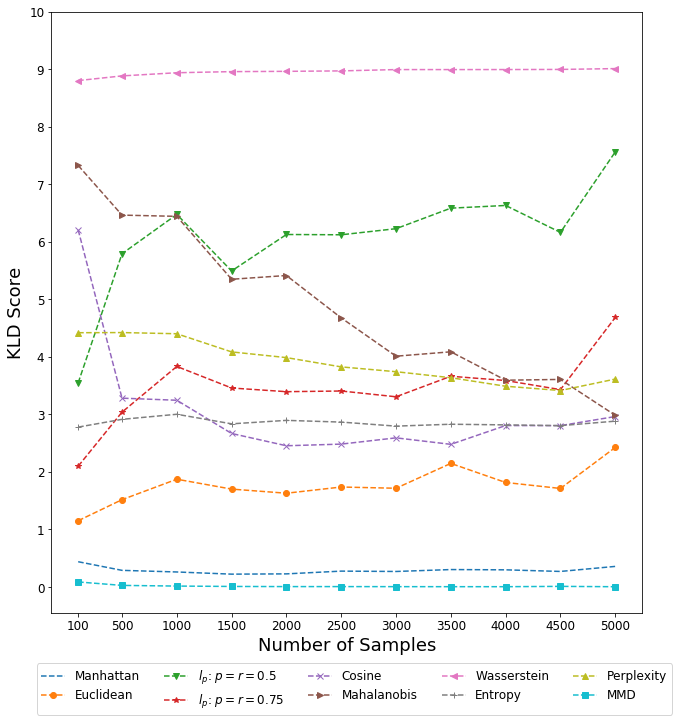

In [14]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(num_sample_list, fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(loc=(-0.025,-.17), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_log.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_log.png')
plt.show()

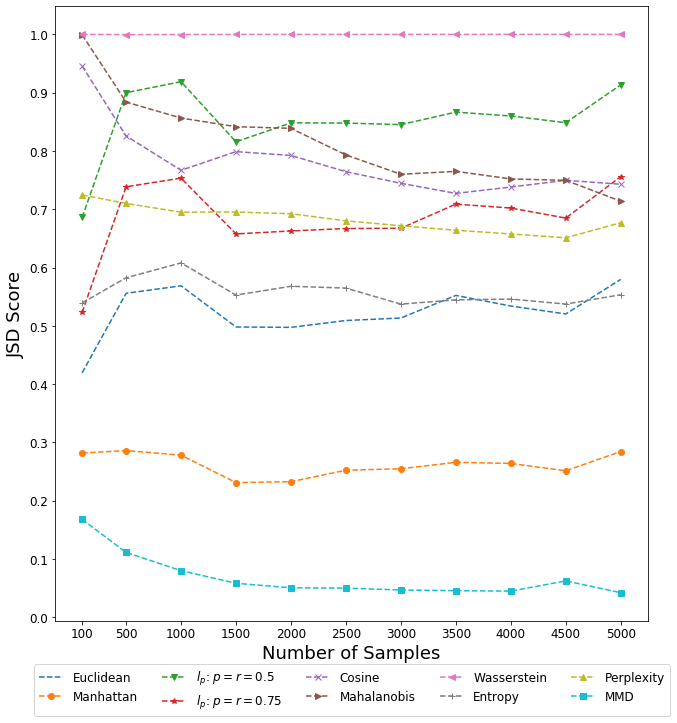

In [23]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(jsd_df.max().max()))
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = jsd_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("JSD Score", fontsize=18)
plt.xticks(num_sample_list,fontsize=12)
plt.yticks(np.arange(0,1.01,0.1), fontsize=12)
plt.legend(loc=(-0.035,-.155), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_log_jsd.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_log_jsd.png')
plt.show()

## PCA

In [23]:
num_metrics = 11
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
sample_efficiency_results_jsd = np.zeros((2, num_metrics, len(num_sample_list)))
counter = 0
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/run/media/mnewlin/_userdata/results_data/results/pca/'
    real_data_pca = pd.read_csv(indir+'real_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0'], axis=1)
    #display(real_data_untrans.head())
    fake_data_pca = pd.read_csv(indir+'fake_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 
              'Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_pca
    fake_data = fake_data_pca
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 4
        grid_y = 3
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
                if count >= num_metrics:
                    break
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd
        plt.close()
        
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd', 'fid']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5    
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)
    fid_KLD = metrics.KL(real_data.loc[:,'fid']/np.sum(real_data.loc[:,'fid']), fake_data.loc[:,'fid']/np.sum(fake_data.loc[:,'fid']), eps=eps)
    
    """
    Add Jensen Shannon Attempt
    
    """
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    fid_JSD = metrics.jensenshannon(real_data.loc[:,'fid']/np.sum(real_data.loc[:,'fid']), fake_data.loc[:,'fid']/np.sum(fake_data.loc[:,'fid']))
    
    """
    """
    kld_data = np.array([euc_KLD, man_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD, fid_KLD])
    jsd_data = np.array([euc_JSD, man_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD, fid_JSD])
    sample_efficiency_results[0,:,counter] = kld_data
    sample_efficiency_results_jsd[0,:,counter] = jsd_data
    counter += 1  
print("Finished")

Finished


In [24]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)
jsd_df = pd.DataFrame(data=sample_efficiency_results_jsd[0], index=names, columns=num_sample_list)
display(jsd_df)

,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,7.561798,7.425514,7.442377,7.480202,7.536159,7.531362,7.578437,7.512969,7.665623,7.621085,7.742283
Manhattan,2.886752,2.256249,1.977460,2.144939,2.207131,1.891644,1.698601,1.901351,1.724827,1.565439,1.620190
lp: p=r=0.5,7.665635,7.485310,7.469198,7.493403,7.500101,7.488860,7.535842,7.511488,7.604376,7.593211,7.716610
lp: p=r=0.75,7.616681,7.460699,7.455252,7.497350,7.525713,7.514679,7.560662,7.526611,7.638384,7.610379,7.728232
cosine,3.799464,3.779491,3.673810,3.743986,3.673115,3.746370,3.694565,3.545639,3.613925,3.664390,3.708640
mahalanobis,3.186080,2.563574,2.279247,2.370935,2.508166,2.209771,1.939853,1.997972,1.689330,1.763042,1.534982
wasserstein,7.958211,6.473582,6.657855,6.686171,6.576329,6.805074,7.003581,6.962251,7.303063,7.222818,7.608641
entropy,8.262377,8.193303,8.173433,8.218564,8.234349,8.219974,8.207327,8.206402,8.218533,8.230864,8.255997
perplexity,7.956245,7.863065,7.839296,7.884329,7.909865,7.881629,7.889721,7.885695,7.899845,7.927460,7.954920
mmd,2.435751,1.535442,1.581831,1.545987,1.560716,1.572440,1.644907,1.636342,1.737448,1.727858,1.856062


,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,1.000000,0.996696,0.998114,0.998226,0.999070,0.998631,0.998888,0.997783,0.998838,0.998436,0.998814
Manhattan,0.604297,0.536309,0.509531,0.539986,0.541338,0.508280,0.489965,0.508124,0.502732,0.480707,0.492122
lp: p=r=0.5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
lp: p=r=0.75,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999936,0.999987,0.999982,1.000000
cosine,0.703769,0.715703,0.709407,0.715631,0.708588,0.716140,0.711323,0.693259,0.698999,0.703583,0.712049
mahalanobis,0.627199,0.580941,0.570729,0.571364,0.579439,0.556891,0.537987,0.545476,0.522943,0.534687,0.523804
wasserstein,1.000000,0.920923,0.911630,0.925989,0.924810,0.919684,0.915815,0.913186,0.916921,0.912512,0.921436
entropy,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
perplexity,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mmd,0.676283,0.602598,0.587285,0.585923,0.577149,0.563253,0.556176,0.553239,0.556200,0.557109,0.565541


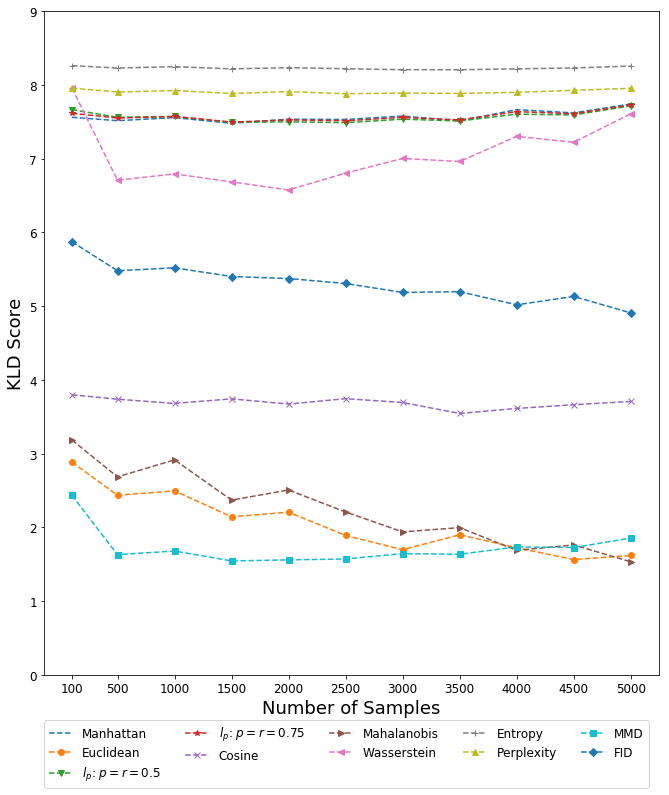

In [17]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
fig = plt.figure(figsize=(10,11))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(num_sample_list, fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(loc=(0,-.17), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_pca.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_pca.png')
plt.show()

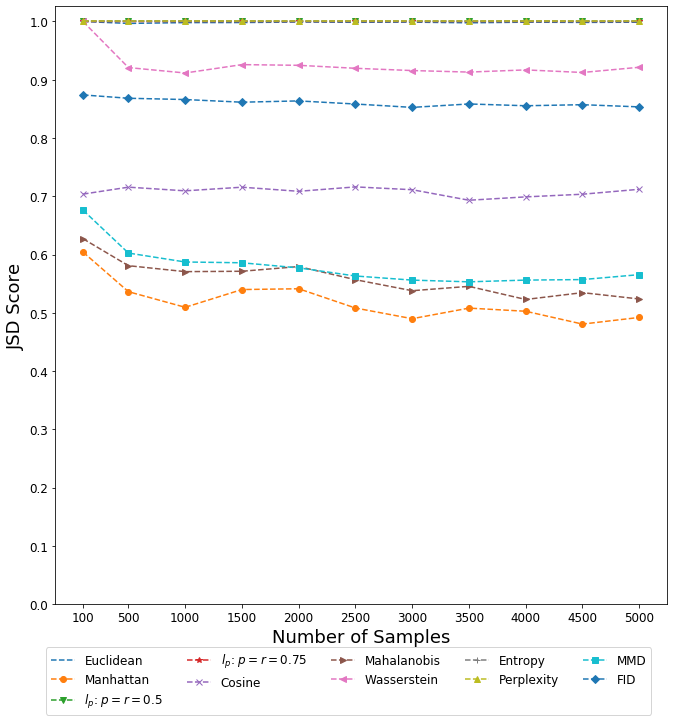

In [25]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(jsd_df.max().max()))
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = jsd_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("JSD Score", fontsize=18)
plt.xticks(num_sample_list,fontsize=12)
plt.yticks(np.arange(0,1.01,0.1), fontsize=12)
plt.legend(loc=(-0.015,-.185), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_pca_jsd.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_pca_jsd.png')
plt.show()

## FFT

In [16]:
num_metrics = 10
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
sample_efficiency_results_jsd = np.zeros((2, num_metrics, len(num_sample_list)))
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
counter = 0
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/run/media/mnewlin/_userdata/results_data/results/fft/'
    real_data_fft = pd.read_csv(indir+'real_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    fake_data_fft = pd.read_csv(indir+'fake_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_fft
    fake_data = fake_data_fft
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 5
        grid_y = 2
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd 
        plt.close()
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)

    """
    Add Jensen Shannon Attempt
    
    """
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    """
    """
    kld_data = np.array([euc_KLD, man_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    jsd_data = np.array([euc_JSD, man_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD])
    sample_efficiency_results[0,:,counter] = kld_data
    sample_efficiency_results_jsd[0,:,counter] = jsd_data
    counter += 1 
print("Finished")    

Finished


In [17]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)
jsd_df = pd.DataFrame(data=sample_efficiency_results_jsd[0], index=names, columns=num_sample_list)
display(jsd_df)

,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,0.460793,0.180579,0.155727,0.143005,0.098333,0.094566,0.098990,0.086695,0.082146,0.077517,0.075981
Manhattan,5.749206,5.239246,5.077483,4.905809,4.957340,4.843451,4.700592,4.766942,4.516384,4.424628,4.279938
lp: p=r=0.5,0.241033,0.133929,0.097694,0.076251,0.075372,0.067171,0.051239,0.047646,0.045636,0.047694,0.038299
lp: p=r=0.75,0.423085,0.179828,0.126714,0.111823,0.104203,0.108179,0.099513,0.104661,0.086859,0.090806,0.078215
cosine,7.823149,7.668476,7.600712,7.681774,7.718561,7.657228,7.663726,7.636024,7.629368,7.621690,7.659186
mahalanobis,7.531427,6.061866,5.539409,6.198177,6.295025,5.866970,5.219866,5.231724,4.781255,4.795868,4.352136
wasserstein,5.533194,2.778847,2.894830,2.539040,2.379068,2.654366,3.098149,3.111587,3.471724,3.386652,3.790521
entropy,8.268327,8.278694,8.286184,8.277605,8.278902,8.278445,8.278116,8.281455,8.282808,8.285260,8.280354
perplexity,7.577916,7.587201,7.593367,7.581111,7.583234,7.585305,7.585896,7.587898,7.589185,7.593404,7.594263
mmd,1.116941,0.938399,0.962985,0.729873,0.657952,0.578496,0.552927,0.631577,0.644533,0.585205,0.648288


,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,0.273210,0.211960,0.196938,0.193279,0.163961,0.159251,0.162436,0.153813,0.149684,0.145529,0.141312
Manhattan,0.860264,0.865059,0.873927,0.841256,0.849897,0.844970,0.841799,0.850409,0.835576,0.827812,0.827802
lp: p=r=0.5,0.236720,0.183881,0.164811,0.148891,0.148136,0.139711,0.121527,0.119956,0.115819,0.119469,0.107721
lp: p=r=0.75,0.269501,0.201536,0.183612,0.180809,0.176876,0.177494,0.171082,0.173959,0.161585,0.165376,0.154683
cosine,0.995809,0.991396,0.988870,0.988393,0.990218,0.988770,0.990603,0.988437,0.988925,0.987713,0.989281
mahalanobis,0.996269,0.910750,0.873376,0.915760,0.917289,0.879800,0.837055,0.834937,0.792979,0.793869,0.749267
wasserstein,0.857553,0.708976,0.688751,0.716411,0.704408,0.693702,0.691646,0.696785,0.696939,0.692052,0.707257
entropy,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999973,1.000000,1.000000,1.000000,0.999980
perplexity,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999973,1.000000,1.000000,0.999982,0.999970
mmd,0.482972,0.503516,0.512899,0.442321,0.425090,0.401363,0.398530,0.423195,0.431005,0.414442,0.426880


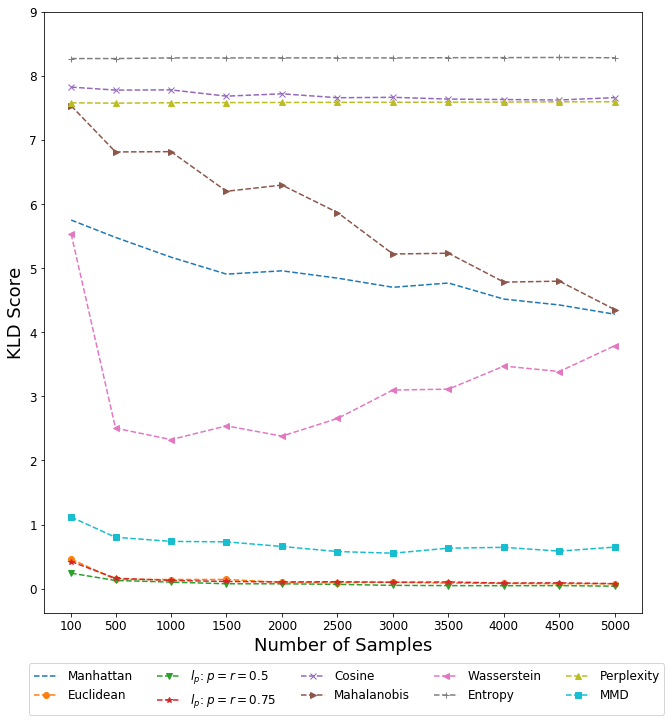

In [9]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))

fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(num_sample_list, fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(loc=(-0.025,-.17), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_fft.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_fft.png')
plt.show()

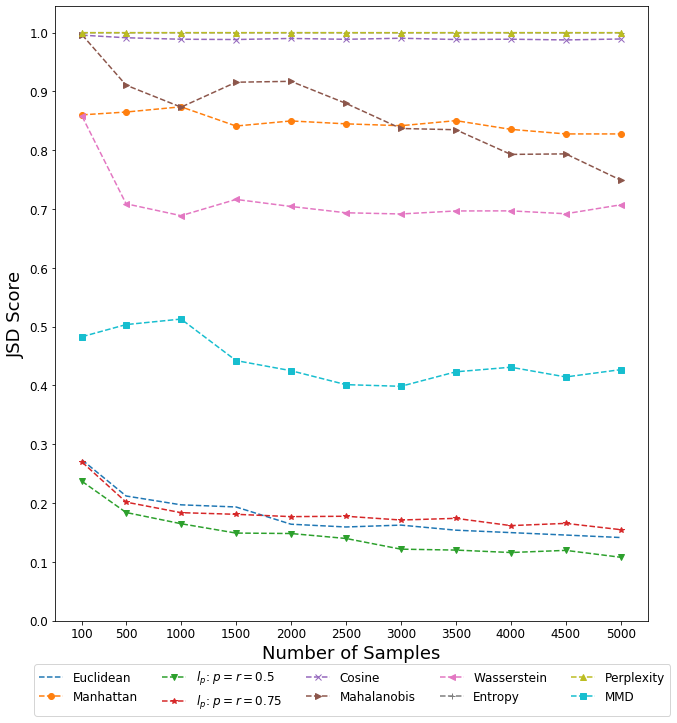

In [18]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(jsd_df.max().max()))
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = jsd_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("JSD Score", fontsize=18)
plt.xticks(num_sample_list,fontsize=12)
plt.yticks(np.arange(0,1.01,0.1), fontsize=12)
plt.legend(loc=(-0.035,-.155), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_fft_jsd.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_fft_jsd.png')
plt.show()

## Epsilon Tuning KLD
Log space since it was most unstable

In [45]:
epsilon_list = np.array([1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2])
num_metrics = 10
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
epsilon_tuning_wass = np.zeros((epsilon_list.size, len(num_sample_list)))
epsilon_tuning_lp1 = np.zeros((epsilon_list.size, len(num_sample_list)))
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']

for z in range(epsilon_list.size):
    sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
    counter = 0

    for x in num_sample_list:
        # Load Sample Efficiency Results
        indir = '/run/media/mnewlin/_userdata/results_data/results/log/'
        real_data_log = pd.read_csv(indir+'real_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
        #display(real_data_untrans.head())
        fake_data_log = pd.read_csv(indir+'fake_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
        #display(fake_data_untrans.head())
        # Get mean KLD score for the 10 runs with x samples
        # Plot Number of samples vs mean KLD with standard deviation shading
        # Looking for KLD threshold of about 3
        titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
        labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
                 'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
        subplots = []
        y_label = 'Count'
        binsize = 100
        alpha_blue = 0.8
        alpha_red = 0.6
        n_repeats = 10
        real_data = real_data_log
        fake_data = fake_data_log

        sample_length = x
        real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
        fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

        for i in range(n_repeats):

            fig = plt.figure(figsize=(15,20))

            grid_x = 5
            grid_y = 2
            grid = mpl.gridspec.GridSpec(grid_x, grid_y)
            count = 0

            r = np.zeros((num_metrics, binsize-1))
            f = np.zeros((num_metrics, binsize-1))
            rr = 0
            rf = 0
            for j in range(grid_x):
                for k in range(grid_y):
                    ax1 = plt.subplot(grid[j,k])
                    if 'Natural' in labels[count]:
                        rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                        rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    elif '10' in labels[count]:
                        rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                        rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    else:
                        rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                        rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    best_bins_min = np.minimum(rr.min(), rf.min()) 
                    best_bins_max = np.maximum(rr.max(), rf.max()) 
                    bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                    real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                    fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                    r[count] = real_hist_data[0]
                    f[count] = fake_hist_data[0]
                    ax1.set_xlabel(labels[count], fontsize=16)
                    ax1.set_ylabel(y_label, fontsize=16)
                    ax1.set_title(titles[count], fontsize=16)
                    ax1.legend(fontsize=16)
                    count += 1
            rd = np.zeros((binsize-1, num_metrics))
            fd = np.zeros((binsize-1, num_metrics))
            for j in range(num_metrics):
                rd[:,j] = r[j]
                fd[:,j] = f[j]

            real_dists[i] = rd
            fake_dists[i] = fd 
            plt.close()
        names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
        cols = []
        for i in range(n_repeats):
            cols.append('Run {}'.format(i+1))
        eps = epsilon_list[z]
        real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
        fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
        euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
        man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
        lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
        lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
        cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
        mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
        wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
        ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
        perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
        mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)

        kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
        sample_efficiency_results[0,:,counter] = kld_data
        #sample_efficiency_results[1,:,counter] = KLD_data_untrans.loc[:,'Std. Dev.']
        counter += 1
    #print("Finished")   
    sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
    epsilon_tuning_wass[z] = sample_eff_res_mean_df.loc['wasserstein']
    epsilon_tuning_lp1[z] = sample_eff_res_mean_df.loc['lp: p=r=0.5']
print("Finished")

Finished


In [46]:
epsilon_tuning_df = pd.DataFrame(data=epsilon_tuning_wass, index = epsilon_list, columns = num_sample_list)
display(epsilon_tuning_df)
epsilon_tuning_df_2 = pd.DataFrame(data=epsilon_tuning_lp1, index = epsilon_list, columns = num_sample_list)
display(epsilon_tuning_df_2)

,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
1.000000e-07,13.409881,13.490673,13.545816,13.565061,13.570138,13.577716,13.600542,13.600442,13.601127,13.603190,13.617622
1.000000e-06,11.106974,11.188162,11.243099,11.262420,11.267422,11.275050,11.297922,11.297775,11.298474,11.300491,11.314964
1.000000e-05,8.801951,8.883176,8.938114,8.957526,8.962479,8.970162,8.993178,8.992970,8.993640,8.995589,9.010160
1.000000e-04,6.482865,6.562380,6.619402,6.639245,6.644387,6.652009,6.675772,6.675562,6.676130,6.677797,6.692841
1.000000e-03,4.094022,4.173012,4.252950,4.278480,4.286211,4.290725,4.317542,4.319779,4.323249,4.322489,4.339904
1.000000e-02,1.716334,1.993170,2.304342,2.406773,2.441088,2.393385,2.409009,2.456840,2.530556,2.505917,2.526028


,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
1.000000e-07,5.525341,8.749166,9.735833,8.033074,9.308315,9.165629,9.367124,9.978925,9.981638,9.280919,11.421804
1.000000e-06,4.537409,7.270874,8.105817,6.762968,7.717570,7.643712,7.797452,8.281723,8.306507,7.722028,9.491682
1.000000e-05,3.548704,5.792412,6.475737,5.492863,6.126817,6.121796,6.227779,6.584520,6.631376,6.163132,7.561553
1.000000e-04,2.555251,4.313373,4.845767,4.222757,4.536162,4.599879,4.658107,4.887318,4.956246,4.604370,5.631540
1.000000e-03,1.544161,2.839749,3.224353,2.952651,2.948347,3.077962,3.088435,3.190115,3.281115,3.048817,3.704548
1.000000e-02,0.655105,1.532192,1.763111,1.682545,1.407594,1.556046,1.518763,1.492913,1.605984,1.544005,1.826425


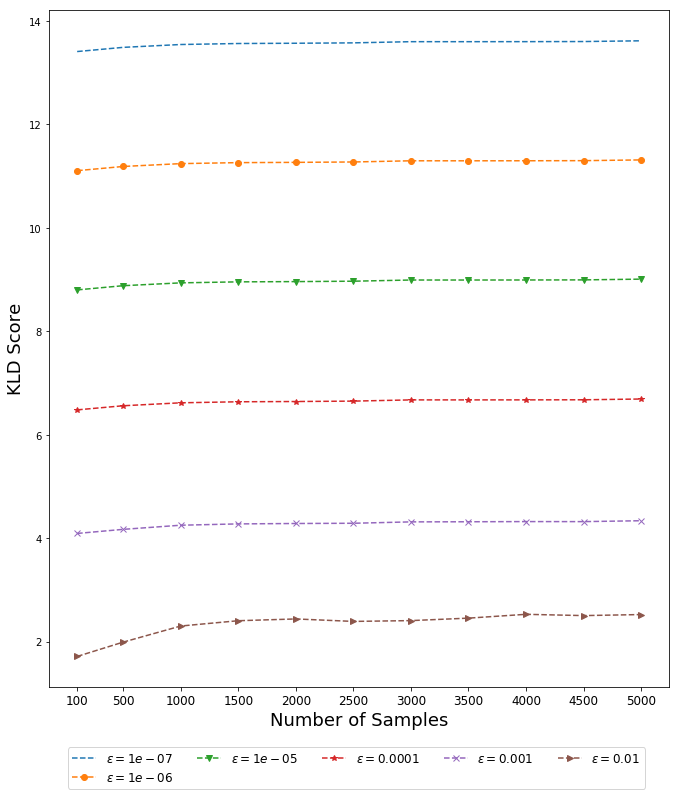

In [47]:
markers = ['--', '--o', '--v', '--*','--x','-->']
fig = plt.figure(figsize=(10,11))
counter = 0
for epsilon in epsilon_list:
    plt.plot(num_sample_list, epsilon_tuning_df.loc[epsilon],markers[counter], label=r'$\epsilon = {}$'.format(epsilon))
    counter += 1
plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(num_sample_list, fontsize=12)
plt.legend(loc=(0.03,-.15), fontsize=12, ncol=5)
plt.tight_layout()
plt.savefig(outdir + 'eps/epsilon_tuning.eps')
plt.savefig(outdir + 'eps/epsilon_tuning.png')
plt.show()

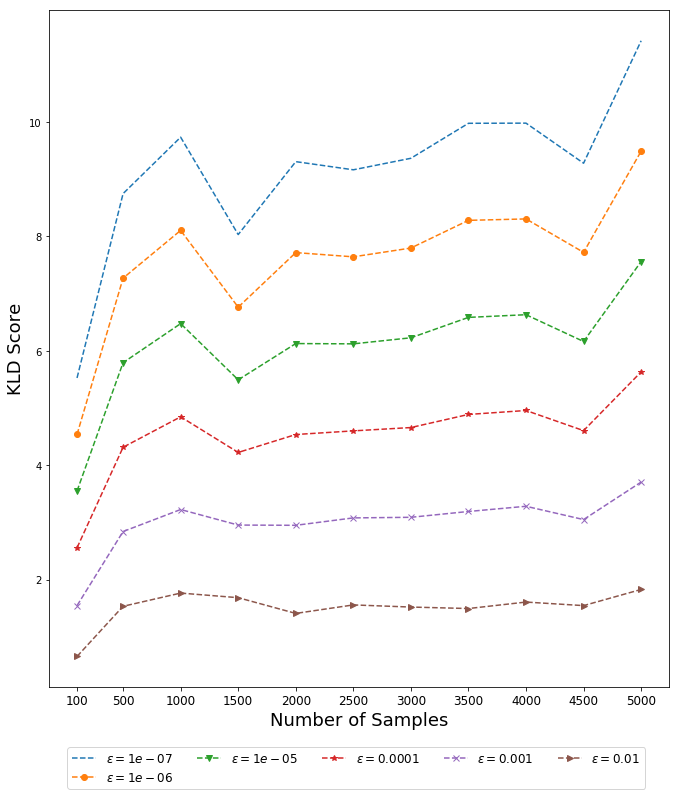

In [48]:
markers = ['--', '--o', '--v', '--*','--x','-->']
fig = plt.figure(figsize=(10,11))
counter = 0
for epsilon in epsilon_list:
    plt.plot(num_sample_list, epsilon_tuning_df_2.loc[epsilon],markers[counter], label=r'$\epsilon = {}$'.format(epsilon))
    counter += 1
plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(num_sample_list, fontsize=12)
plt.legend(loc=(0.03,-.15), fontsize=12, ncol=5)
plt.tight_layout()
plt.savefig(outdir + 'eps/epsilon_tuning_2.eps')
plt.savefig(outdir + 'eps/epsilon_tuning_2.png')
plt.show()

## Untransformed

In [19]:
num_metrics = 10
num_sample_list = [(n+1)*100 for n in range(10)]
#num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
sample_efficiency_results_jsd = np.zeros((2, num_metrics, len(num_sample_list)))
counter = 0
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/run/media/mnewlin/_userdata/results_data/results/untrans/'
    real_data_untrans = pd.read_csv(indir+'real_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(real_data_untrans.head())
    fake_data_untrans = pd.read_csv(indir+'fake_data_exp_eff_host_uniform_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_untrans
    fake_data = fake_data_untrans
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 5
        grid_y = 2
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd 
        plt.close()
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5
    #KLD_data_all = np.zeros((num_metrics, n_repeats))
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)
    """
    Add Jensen Shannon Attempt
    
    """
    euc_JSD = metrics.jensenshannon(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']))
    man_JSD = metrics.jensenshannon(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']))
    lp1_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']))
    lp2_JSD = metrics.jensenshannon(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']))
    cos_JSD = metrics.jensenshannon(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']))
    mah_JSD = metrics.jensenshannon(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']))
    wass_JSD = metrics.jensenshannon(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']))
    ent_JSD = metrics.jensenshannon(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']))
    perp_JSD = metrics.jensenshannon(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']))
    mmd_JSD = metrics.jensenshannon(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']))
    
    """
    """
    kld_data = np.array([euc_KLD, man_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    jsd_data = np.array([euc_JSD, man_JSD, lp1_JSD, lp2_JSD, cos_JSD, mah_JSD, wass_JSD, ent_JSD, perp_JSD, mmd_JSD])
    sample_efficiency_results[0,:,counter] = kld_data
    sample_efficiency_results_jsd[0,:,counter] = jsd_data
    #sample_efficiency_results[1,:,counter] = KLD_data_untrans.loc[:,'Std. Dev.']
    counter += 1    
    #KLD_data_all[:,i] = kld_data.T

In [20]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)
jsd_df = pd.DataFrame(data=sample_efficiency_results_jsd[0], index=names, columns=num_sample_list)
display(jsd_df)

,100,200,300,400,500,600,700,800,900,1000
Euclidean,1.028608,1.442394,1.509243,1.646717,1.858121,1.645046,1.580538,1.893939,1.601764,1.903830
Manhattan,0.281119,0.292580,0.241002,0.284764,0.302565,0.231853,0.206606,0.231744,0.227210,0.227552
lp: p=r=0.5,3.262993,4.598187,5.778704,6.218713,7.160395,6.420313,6.338431,6.257116,6.381946,7.337312
lp: p=r=0.75,1.876092,2.333605,3.502096,3.680799,4.161512,3.769653,3.735206,3.600939,3.548721,4.332673
cosine,6.343285,3.596981,3.602426,3.552630,3.605490,3.195588,3.327280,3.067255,3.083442,2.747027
mahalanobis,7.326701,6.432638,6.449779,6.464226,5.737633,5.754498,5.755106,5.075329,5.099171,5.091530
wasserstein,8.765616,8.813388,8.837461,8.850002,8.866530,8.883127,8.896920,8.907489,8.919049,8.911139
entropy,3.094676,3.271570,3.321669,3.392280,3.467485,3.362491,3.362750,3.471890,3.430251,3.562170
perplexity,4.846237,4.770349,4.852216,4.908331,4.695175,4.760121,4.666497,4.547971,4.515147,4.519391
mmd,0.081689,0.076649,0.046315,0.045396,0.030026,0.028943,0.035422,0.026770,0.025249,0.021203


,100,200,300,400,500,600,700,800,900,1000
Euclidean,0.399265,0.431002,0.466335,0.487205,0.514341,0.498045,0.494245,0.508984,0.503382,0.523166
Manhattan,0.243089,0.232922,0.223111,0.235702,0.244060,0.229154,0.217851,0.224748,0.213476,0.231184
lp: p=r=0.5,0.671567,0.752707,0.811191,0.829473,0.894036,0.862831,0.860440,0.857501,0.867227,0.911245
lp: p=r=0.75,0.508087,0.566734,0.638943,0.661744,0.709954,0.684237,0.684682,0.685179,0.687014,0.721186
cosine,0.950514,0.865373,0.871726,0.875904,0.834015,0.820861,0.831586,0.792467,0.788922,0.777927
mahalanobis,0.999097,0.922062,0.923516,0.924481,0.887759,0.889762,0.889842,0.856986,0.864067,0.857213
wasserstein,1.000000,0.999364,0.999586,0.999682,0.999610,0.999664,0.999721,0.999709,0.999742,0.999768
entropy,0.589535,0.607640,0.613475,0.625220,0.651810,0.608643,0.622737,0.646841,0.636979,0.679444
perplexity,0.767953,0.756555,0.762226,0.770070,0.753247,0.746217,0.744864,0.734468,0.736109,0.737909
mmd,0.163617,0.150772,0.120350,0.121130,0.101479,0.099929,0.107707,0.094286,0.089958,0.085531


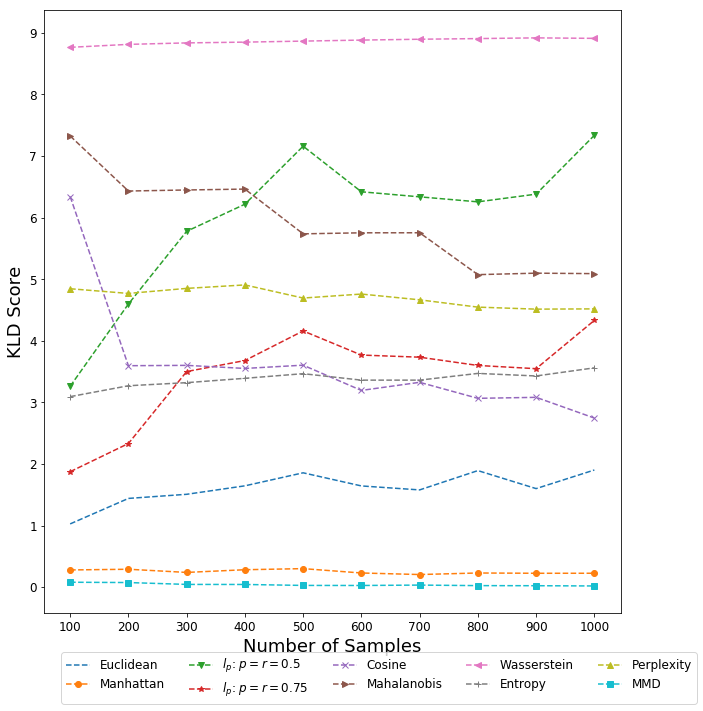

In [6]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(num_sample_list,fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(loc=(0.03,-.15), fontsize=12, ncol=5)
plt.tight_layout()

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_untrans_small_size.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_untrans_small_size.png')
plt.show()

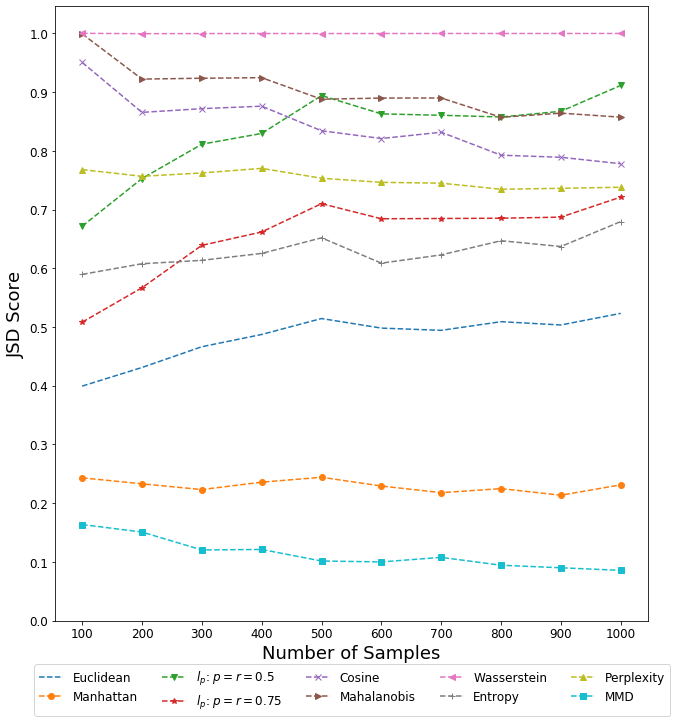

In [22]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(jsd_df.max().max()))
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = jsd_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("JSD Score", fontsize=18)
plt.xticks(num_sample_list,fontsize=12)
plt.yticks(np.arange(0,1.01,0.1), fontsize=12)
plt.legend(loc=(-0.035,-.155), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_host_untrans_small_size_jsd.pdf')
plt.savefig(outdir + 'png/sample_efficiency_host_untrans_small_size_jsd.png')
plt.show()